In [1]:
! pip install lineapy


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
! python -m pip install pandas==1.3.2


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
%load_ext lineapy

In [4]:
lineapy.options

lineapy_config(home_dir=PosixPath('/Users/jenif/.lineapy'), database_url='sqlite:////Users/jenif/.lineapy/db.sqlite', artifact_storage_dir=PosixPath('/Users/jenif/.lineapy/linea_pickles'), customized_annotation_folder=PosixPath('/Users/jenif/.lineapy/custom-annotations'), do_not_track=False, logging_level='INFO', logging_file=PosixPath('/Users/jenif/.lineapy/lineapy.log'), storage_options=None, mlflow_registry_uri=None, mlflow_tracking_uri=None, default_ml_models_storage_backend=None)

In [5]:
import lineapy
import joblib
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Load dataset

In [6]:
# Get data 

import pandas as pd
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
dataset = data.frame
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# print labels for target values 

[print(f'{target}: {label}') for target, label in zip(data.target.unique(), data.target_names)]

0: setosa
1: versicolor
2: virginica


[None, None, None]

In [8]:
# feature names

dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [9]:
#save raw data as artifact
dataset_csv = './data/raw/iris.csv'
dataset.to_csv(dataset_csv, index=False)


In [10]:
dataset

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [11]:
print(pd.__version__)

1.3.2


In [12]:
#save raw data as artifact to lineapy
lineapy.save(dataset, "iris-raw")

LineaArtifact(name='iris-raw', _version=4)

# Features engineering

In [13]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
#     'sepal_length_in_square', 'sepal_width_in_square', 'petal_length_in_square', 'petal_width_in_square',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'target'
]]

In [14]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


In [15]:
# Save features
features_path = './data/processed/featured_iris.csv'
dataset.to_csv(features_path, index=False)

In [16]:
#save features to lineapy
lineapy.save(dataset, "iris-preprocessed")

LineaArtifact(name='iris-preprocessed', _version=4)

# Split dataset

In [17]:
test_size=0.2

## Splittail train/test

In [18]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

In [19]:
# Save train and test sets
trainset_path = './data/processed/train_iris.csv'
testset_path = './data/processed/test_iris.csv'

train_dataset.to_csv(trainset_path)
test_dataset.to_csv(testset_path)

In [20]:
#save train and test sets to lineapy
lineapy.save(train_dataset, "train-dataset")
lineapy.save(test_dataset, "test-dataset")

LineaArtifact(name='test-dataset', _version=4)

# Train

In [21]:
# Get X and Y

y_train = train_dataset.loc[:, 'target'].values.astype('int32')
X_train = train_dataset.drop('target', axis=1).values.astype('float32')

In [22]:
# Create an instance of Logistic Regression Classifier CV and fit the data

logreg = LogisticRegression(C=0.001, solver='lbfgs', multi_class='multinomial', max_iter=100)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, multi_class='multinomial')

In [23]:
model_path= './models/model.joblib'
joblib.dump(logreg, model_path)

['./models/model.joblib']

In [24]:
#save model to lineapy
lineapy.save(model_path, "logreg-model")

LineaArtifact(name='logreg-model', _version=3)

# Evaluate

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    return plt.gcf()

In [33]:
# Get X and Y

y_test = test_dataset.loc[:, 'target'].values.astype('int32')
X_test = test_dataset.drop('target', axis=1).values.astype('float32')

In [34]:
prediction = logreg.predict(X_test)
cm = confusion_matrix(prediction, y_test)
f1 = f1_score(y_true = y_test, y_pred = prediction, average='macro')

In [35]:
# f1 score value
f1

0.9305555555555555

In [36]:
# Save metrics
metrics_file = './reports/metrics.json'

metrics = {
    'f1': f1
}

with open(metrics_file, 'w') as mf:
    json.dump(
        obj=metrics,
        fp=mf,
        indent=4
    )


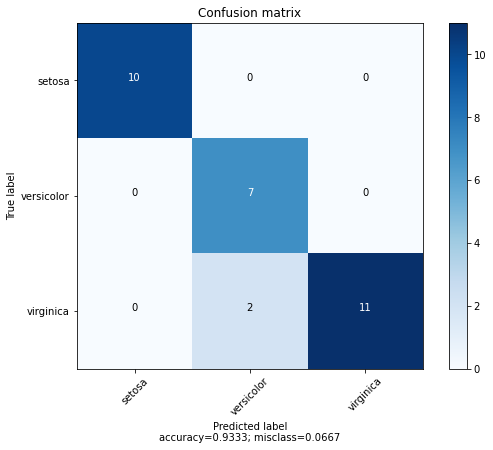

In [37]:
cm_plot = plot_confusion_matrix(cm, data.target_names, normalize=False)

In [39]:
# Save confusion matrix image
confusion_matrix_image = './reports/confusion_matrix.png'
cm_plot.savefig(confusion_matrix_image)

In [40]:
#save confusion matrix to lineapy
lineapy.save(plot_confusion_matrix, "plot-confusion-matrix")

LineaArtifact(name='plot-confusion-matrix', _version=1)

In [ ]:
#commenting for change
